# CS 109A/AC 209A/STAT 121A Data Science: Homework 7
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 9th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW7.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
import StringIO
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

Farmer, Rick

### Part (b): Course Number

CS 109a

### Part (c): Who did you work with?

N/A

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Monitoring Land Cover Changes Using Satellite Images
In the face of rapid urban development and climate change, it is now more urgent than ever for governments (and other organizations) to have a detailed, accurate and up-to-date picture of land use and land cover, as well as how the land use/cover is changing over time, in order to make effective policy decision to manage and protect natural resources. Building such a comprehensive picture of land use/cover for a large region is extremely difficult. 

Recent improvements in satellite imagery and image process have allowed for new tools in land use/cover analysis. The following is an image of the change in vegetation cover around Belize from 1975 to 2007:

<img src="sat.jpg">

In this problem, we will explore how to use classifiers to detect the presence and location of vegetation in satellite images.


### Part 1(a): Detecting vegetation in satellite images

The following files contain sampled locations from satelite aeriel images: `dataset_1.txt`, ... `dataset_4.txt`. The first two columns contain the normalized latitude and longitude values. The last column indicates whether or not the location contains vegetation, with 1 indicating the presence of vegetaion and 0 indicating otherwise. 

These small sets of labels are typically generated by hand (that is, locations might be classified based on field studies or by cross-referencing with government databases). Your task is to use the labeled locations to train a model that will predict whether a new location is vegetation or non-vegetation.

- Suppose we were asked to write a computer program to automatically identify the vegetation regions on the landscape. How can we use the model fitting algorithms you have studied so far to identify the boundaries of the vegetation regions? In particular, discuss the suitability of the following algorithms for each of the four data sets (**you do not need to evaluate your classifier, build your argument using data and decision boundary visualizations**): 
    - linear or polynomial linear regression
    - linear or polynomial logistic regression
    - linear or quadratic discriminant analysis
    - decision trees

- By a quick visual inspection of each data set, what do you think is the smallest depth decision tree that would provide a good fit of the vegetation boundaries in each case? Does `sklearn`'s decision tree fitting algorithm always provide a good fit for the proposed depth? If not, explain why. **Support your answer with suitable visualization**.


### Step 1: Load the data and explore

Let's load the four datasets and visualize the data. That is, let's plot the data points by longitude and latitude. Let's also color code the points: green if the location is vegetation and white otherwise.

In [3]:
#Load the data from satellite image #1 
sat_img_1 = pd.read_csv('datasets/dataset_1.txt', delimiter=',', header=None)
#Check out the data - sanity check
sat_img_1.head()

,0,1,2
0,0.566809,0.788130,1.0
1,0.400046,0.620933,1.0
2,0.458702,0.536935,1.0
3,0.474504,0.638224,1.0
4,0.558707,0.715527,1.0


In [4]:
#The data looks ok, so let's load the rest of the images
sat_img_2 = pd.read_csv('datasets/dataset_2.txt', delimiter=',', header=None)
sat_img_3 = pd.read_csv('datasets/dataset_3.txt', delimiter=',', header=None)
sat_img_4 = pd.read_csv('datasets/dataset_4.txt', delimiter=',', header=None)

#Make a list of the four dataframes so we can iterate through them later
sat_images = [sat_img_1, sat_img_2, sat_img_3, sat_img_4]

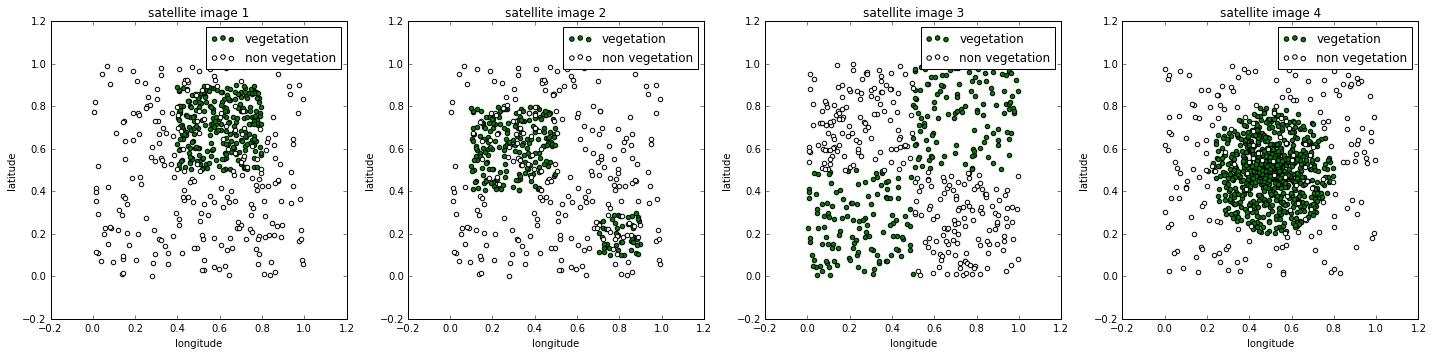

In [5]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]
    
    #Plot vegetation locations as green dots
    ax[i].scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation')
    #Plot non-vegetation locations as white dots
    ax[i].scatter(x[y == 0, 0], x[y == 0, 1], c='white', label='non vegetation')
    
    #Label everything
    ax[i].set_xlabel('longitude')
    ax[i].set_ylabel('latitude')
    ax[i].set_title('satellite image {}'.format(i + 1))
    ax[i].legend()
    
plt.tight_layout()
plt.show() 

For each image, based on the sample of we want to train a classifier that will classify a location as vegetation or non-vegetation.

Since the vegetation seem to be clustered in isolated regions in each image. Classifying locations with vegetation involves learning a boundary around each region. We then classify the points inside this region as vegetation and points outside as non-vegetation.

Formally speaking, the vegetation regions in an image can be identified by treating the latitude and longitude values as predictors and the vegetation information as a binary response, and fitting a classification model. The decision boundaries of these classifiers then allow us to identify the vegetation regions.

### Step 2: Classify locations with vegetation

How can we use the models we have studied so far to identify the boundaries of the vegetation regions? 

Let's consider:

    1. linear or polynomial logistic regression
    2. linear or quadratic discriminant analysis
    3. decision trees


We provide you with a function `plot_tree_boundary` to visualize a decision tree model on the data set.

In [9]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (classifier)
#      poly_flag (fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='white')
    
    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

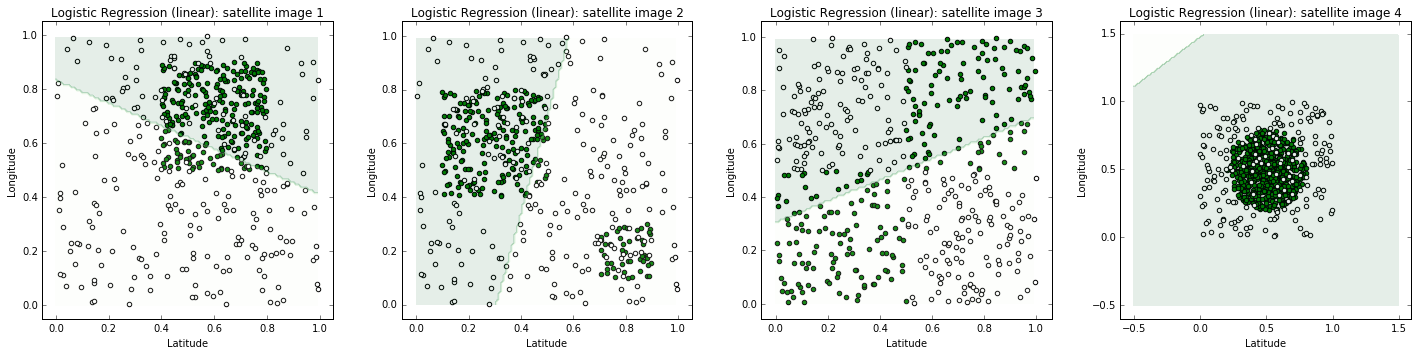

In [10]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Create a logistic regression model with linear boundary
logreg = linear_model.LogisticRegression()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]    
    
    #Fit our logistic regression model
    logreg.fit(x, y)
    
    #Change the bounds on the scatter plot (the 4th dataframe needs a larger frame)
    if i == 3:
        bounds = (-0.5, 1.5)
    else:
        bounds = (0, 1)
    
    #Plot the data along with the decision boundary learned by our model
    ax[i] = plot_decision_boundary(x, y, logreg, 
                                   'Logistic Regression (linear): satellite image {}'.format(i + 1), 
                                   ax[i], bounds)
    

plt.tight_layout()
plt.show()

[[-15.77894455  45.60378485  57.83803683 -49.26360545  20.21789142
  -49.05437198]]
[[ -6.73240213  24.55549166  39.27037449 -12.05924263 -32.74808594
  -25.06270608]]
[[  17.81235335  -69.52466362  -73.20036526   -2.01345227  143.18659591
     2.28258713]]
[[ -8.08706466  44.31032286  39.35848862 -45.08081672   1.57093006
  -41.48122868]]


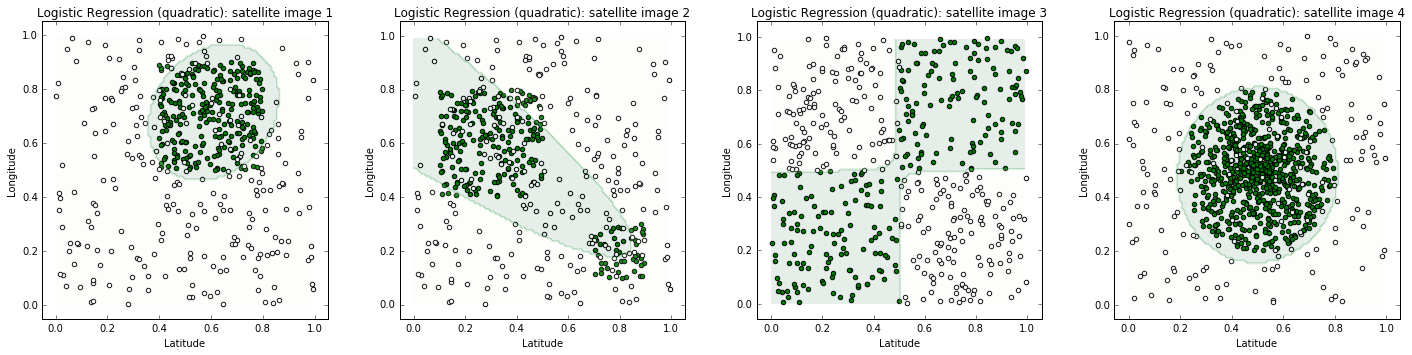

In [11]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Logistic Regression with Quadratic Terms
logreg_poly = linear_model.LogisticRegression(C=1000)

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Expand our predictor array with quadratic terms
    quad_features = preprocessing.PolynomialFeatures(degree = 2)
    x_expanded = quad_features.fit_transform(x)
    
    #Fit logistic regression model with quadratic decision boundary
    logreg_poly.fit(x_expanded, y)
    print logreg_poly.coef_
    
    #Plot the data along with the decision boundary learned by our model
    ax[i] = plot_decision_boundary(x, y, logreg_poly, 'Logistic Regression (quadratic): satellite image {}'.format(i + 1), ax[i], poly_flag=True)
    

plt.tight_layout()
plt.show()

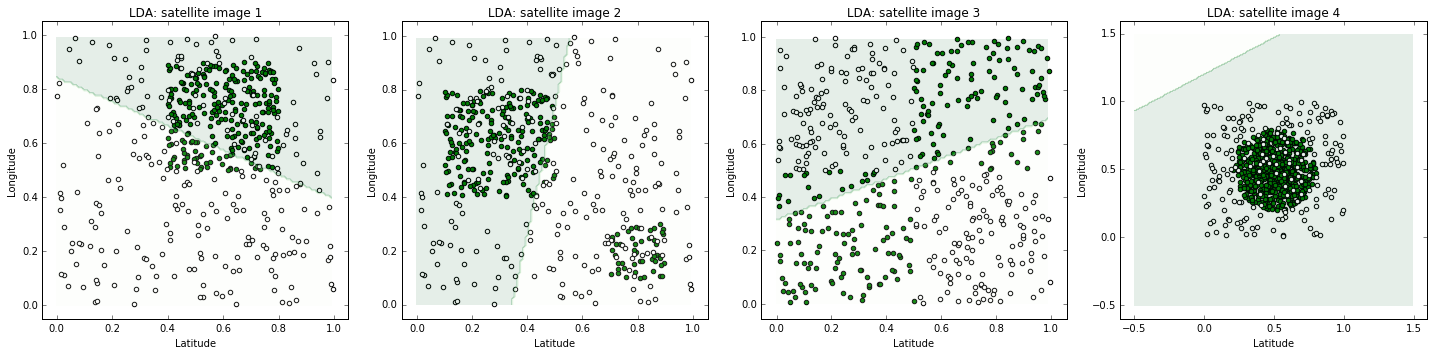

In [12]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# LDA
lda = discriminant_analysis.LinearDiscriminantAnalysis()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Fit our LDA model
    lda.fit(x, y)
    
    #Change the bounds on the scatter plot (the 4th dataframe needs a larger frame)
    if i == 3:
        bounds = (-0.5, 1.5)
    else:
        bounds = (0, 1)
        
    #Plot the data along with the decision boundary learned by our model    
    ax[i] = plot_decision_boundary(x, y, lda, 'LDA: satellite image {}'.format(i + 1), ax[i], bounds)
    

plt.tight_layout()
plt.show()

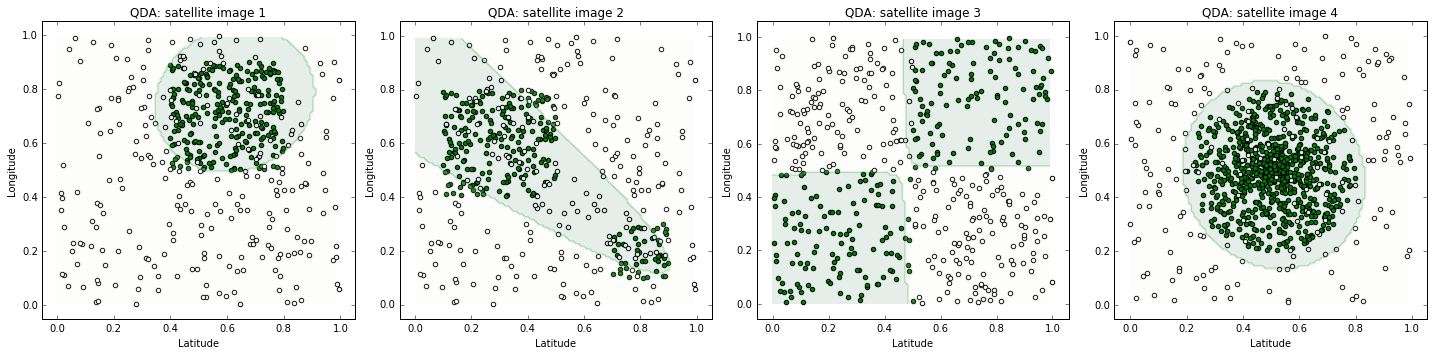

In [13]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Logistic Regression with Quadratic Terms
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Fit our QDA model
    qda.fit(x, y)
        
    #Plot the data along with the decision boundary learned by our model 
    ax[i] = plot_decision_boundary(x, y, qda, 'QDA: satellite image {}'.format(i + 1), ax[i])
    

plt.tight_layout()
plt.show()

- **Linear logistic regression / LDA:** Given that the vegetation regions are rectangular or elliptical in shape, a linear classification is not well-suited.

- **Quadratic logistic regression / QDA:** These methods will be able to accurately detect the vegetation regions in `dataset_4`, but will not be good fits the other data sets.

- **Decision trees:** This method will provide good fits for the first three data sets, where the region boundaries are rectangular. A decision tree is not best suited `dataset_4`, as to get a good fit, the tree depth needs to be very large. 

We've built you a helper function `plot_decision_boundary` to visualize a decision tree model on the data set.

In [14]:
#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax):
    # PLOT DATA
    ax.scatter(x[y==1,0], x[y==1,1], c='green')
    ax.scatter(x[y==0,0], x[y==0,1], c='white')
    
    # CREATE MESH
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [15]:
#--------  fit_and_plot_dt
# Fit decision tree with on given data set with given depth, and plot the data/model
# Input: 
#      fname (string containing file name)
#      depth (depth of tree)

def fit_and_plot_dt(x, y, depth, title, ax):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax)
    
    return ax

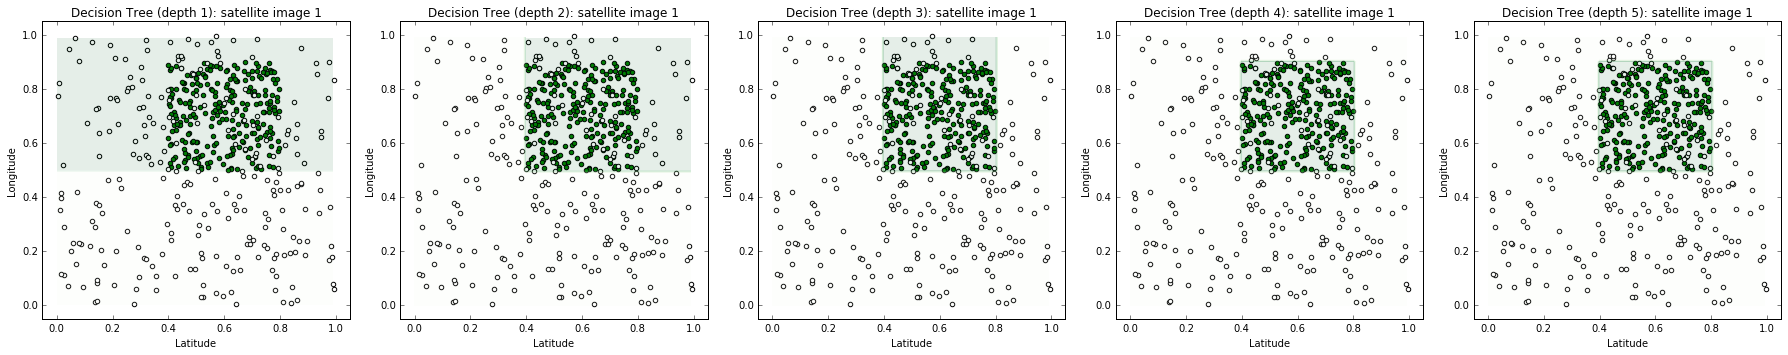

In [16]:
# Plot for dataset_1.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = sat_images[0].values[:, :-1]
#Get the class labels
y = sat_images[0].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 1'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

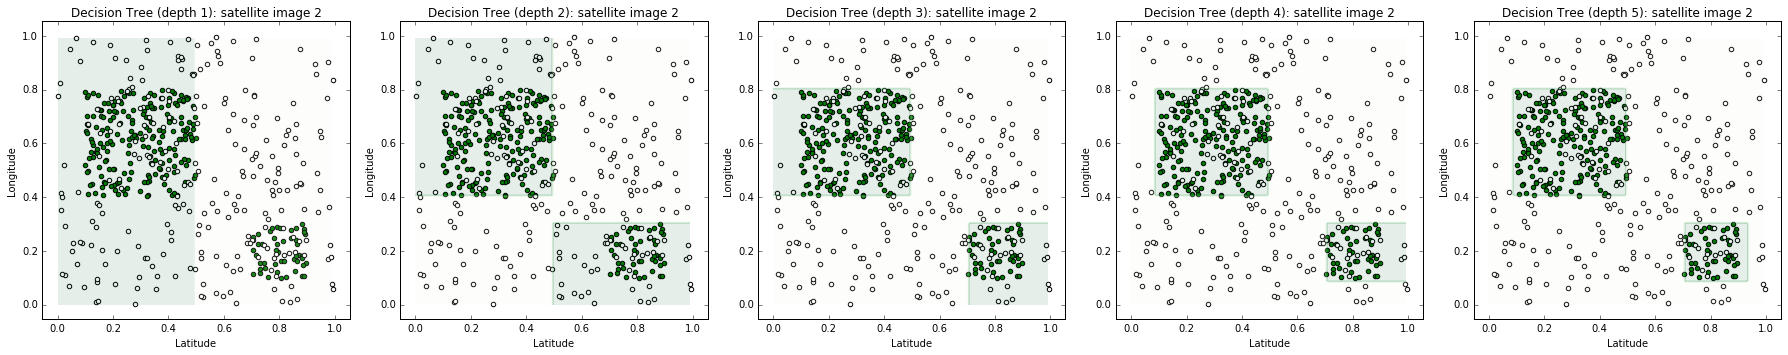

In [17]:
# Plot for dataset_2.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))

#Get the long/lat coords
x = sat_images[1].values[:, :-1]
#Get the class labels
y = sat_images[1].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 2'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

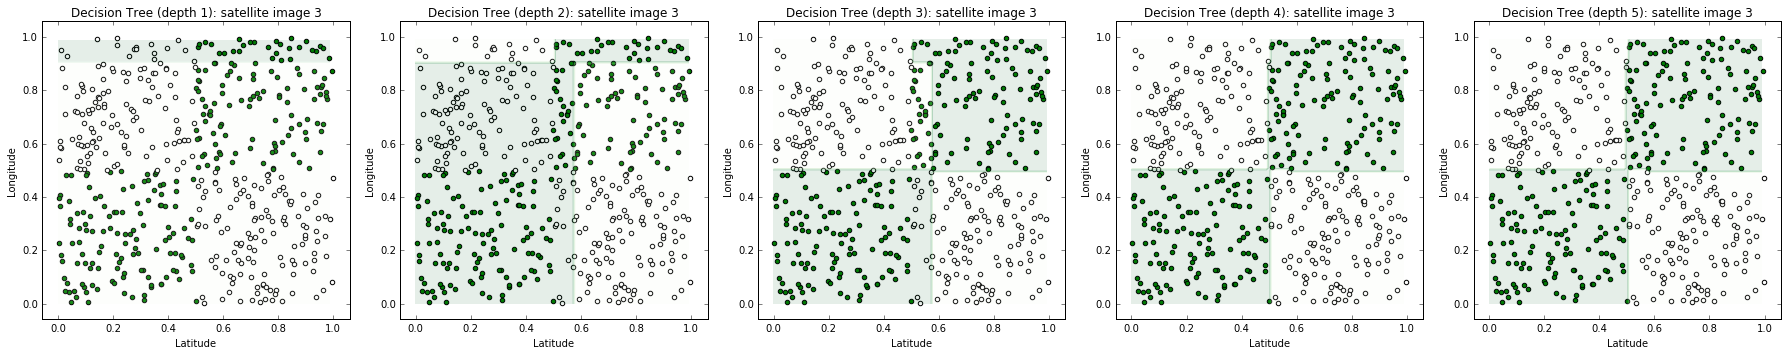

In [18]:
# Plot for dataset_3.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))

#Get the long/lat coords
x = sat_images[2].values[:, :-1]
#Get the class labels
y = sat_images[2].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 3'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

Since the vegetation region in dataset 1 takes the shape of a rectangle, a decision tree with a minimum depth of 4 is needed to define this region: one to check each of left x-limit, right x-limit, lower y-limit and upper y-limit. 

The vegetation in dataset 2 spans two rectangles of different sizes, a naive guess would be that we need a decision tree of depth 8, one for each corner of the two rectangles. However it suffices to use a simpler **5-level** tree: each rectangle can be captured by a decision tree of depth 4, and the root node branches to one of these trees.

Since the vegetation region in dataset 1 takes the shape of two rectangles lined up along their diagonals.  A depth 2 decision tree would have sufficed for this data set. However, due to the **greedy nature** of the fitting algorithm, we needed to go up to depth 4 to get a good fit. This is due to a sub-optimal local choice at higher depths.

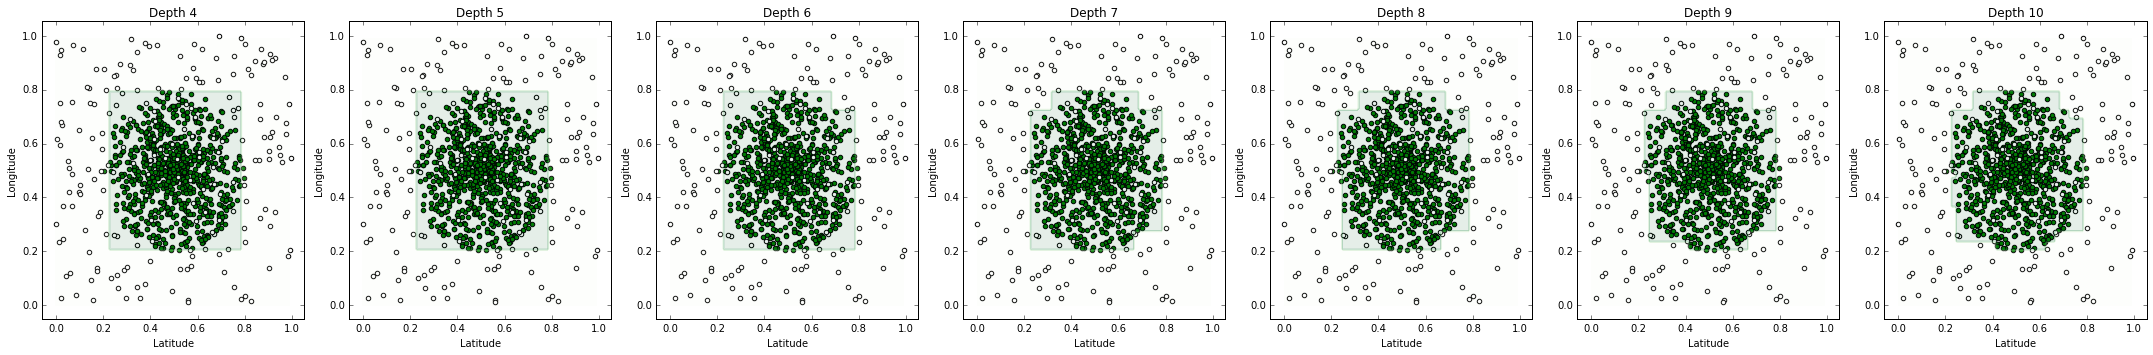

In [19]:
# Plot for dataset_4.txt: depths 1 through 26
fig, ax = plt.subplots(1, len(range(4, 11, 1)), figsize=(30, 5))

#Get the long/lat coords
x = sat_images[3].values[:, :-1]
#Get the class labels
y = sat_images[3].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(4, 11, 1):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Depth {}'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1
    
plt.tight_layout()
plt.show()

Since the vegetation is circular in shape, a decision tree with infinite depth is required to fit this data set.

### Part 1(b). What is the best splitting criterion for decision trees?
Suppose you are given a data set with 100 points in a satellite image, of which 51 are class 1 and 49 are class 0. Consider following two candidate splits for constructing a decision tree: 
1. [Part 1 = (Class 1: 11, Class 0: 37), Part 2 = (Class 1: 40, Class 0: 12)]
2. [Part 1 = (Class 1: 25, Class 0: 48), Part 2 (Class 1: 26, Class 0: 1)]

Which of these is a better split according classification error, Gini coefficient, and Entropy criteria? Do the three criteria agree on the best split, or is one better than the other? Support your answer with a concrete explanation.

### Step 3: Evaluate our modeling choices

Recall that when creating our decision tree, we can decide on a split according classification error, Gini coefficient, and Entropy criteria. Which criterion is better, i.e. yield a better model? Or perhaps all three criteria will always produce the same splits?

Let's explore these three criteria using a simple example.

Suppose you are given a data set with 100 points in a satellite image, of which 51 are class 1 and 49 are class 0. Consider following two candidate splits for constructing a decision tree: 
1. $((11,37), (40,12))$  
2. $((25,48), (26,1))$

In [22]:
# Calculate classification accuracy for a binary split
def err(x1, x2):
    return min((x1,x2))

# Calculate Gini coefficient for a binary split
def Gini(x1, x2):
    return x1*(1-x1) + x2*(1-x2)

# Calculate Cross-entropy for a binary split
def entropy(x1, x2):
    return -x1*np.log(x1) - x2*np.log(x2)

# Split 1:

# Compute split counts
n11 = 48
n12 = 52
n1 = n11 + n12

# Compute split probabilities
x1 = 11./n11
x2 = 37./n11
y1 = 40./n12
y2 = 12./n12

print('Split 1')
print('Error = ' + str((n11*err(x1,x2)+n12*err(y1,y2))/n1))
print('Gini = ' + str((n11*Gini(x1,x2)+n12*Gini(y1,y2))/n1))
print('Entropy = ' + str((n11*entropy(x1,x2)+n12*entropy(y1,y2))/n1))

print('')

# Compute split counts
n21 = 73
n22 = 27
n2 = n21 + n22

# Split 2:
x1 = 25./n21
x2 = 48./n21
y1 = 26./n22
y2 = 1./n22

print('Split 2')
print('Error = ' + str((n21*err(x1,x2)+n22*err(y1,y2))/n2))
print('Gini = ' + str((n21*Gini(x1,x2)+n22*Gini(y1,y2))/n2))
print('Entropy = ' + str((n21*entropy(x1,x2)+n22*entropy(y1,y2))/n2))

Split 1
Error = 0.23
Gini = 0.354198717949
Entropy = 0.539274531592

Split 2
Error = 0.26
Gini = 0.348026382547
Entropy = 0.511910804521


**Observation:** 
While Split 1 has lower error, Split 2 is better, as the partitions are *purer* - the right-hand partition contains an almost perfect classification.

Gini coefficient and Cross-entropy choose Split 2 over Split 1, showing that they promote purer splits. This shows that these are better criteria are than error.

What is the default criterion `sklearn` uses in its decision tree classifier model? Will changing this criterion make any difference in terms of the preformance of our classifier on the satellite images?

## Problem 2: Loan Risk Assessment
In this problem, you are asked by an Unamed National Bank to build a risk assessment model that predicts whether or not it is risky to give a loan to an applicant based on the information provided in their application. Traditionally, loan applications are processed and assessed by hand, but now the bank wants to move to an automated loan processing system. That is, the bank will provide you with loan applications that it has processed in the past for you to build a classifier for risk assessment, going forward, the bank will reject the loan applications from applicants labeled risky and approve the applications that are labeled safe by your model.

The relevant training and test sets are provided in the files: `dataset_5_train.txt` and `dataset_5.test.txt`. The training and testing sets are created from both approved and rejected loan applications that the bank has processed by hand in the past. The first 24 columns contain attributes for each applicant gathered from their application, and the last column contains the credit risk assessment with 1 indicating that the customer is a loan risk, and 0 indicating that the customer is not a loan risk. The names of the attributes are provided in the file `dataset_5_description.txt`.


### Part 2(a): A simple decision tree model
- Fit a simple decision tree of depth 2 to the training set and report its accuracy on the test set. 

- Interpret the way your model performs risk classifcation. Would you recommend this classifier to Unamed National Bank for making decisions on the loan applications of **real people**? If yes, make an argument for the merrits of this classifer. If no, then make necessary changes to the data set and fit a new classifier that you believe is fair to use in practice, then compare the two classifiers.


We have provided you with a function `display_dt` to display the structure of the decision tree in DOT format.

In [138]:
# Print decision tree model 'model', already fitted
def display_dt(model):
    dummy_io = StringIO.StringIO() 
    tree.export_graphviz(dt, out_file = dummy_io) 
    print dummy_io.getvalue()

### Part 2(b): An ensemble of decision trees

- One way to improve the prediciton accuracy for this task is to use an ensemble of decision trees fitted on random samples, as follows: given a training set of size $n$, sample new training sets uniformly with replacement, and fit a decision tree model on each random sample.

  Now, how would you combine the ensemble into a single classifier? There are at lease two ways:

   - *Random classifier*: predict using a randomly chosen decision tree from the ensemble
   - *Majority classifier*: predict using the majority vote from decision trees in the ensemble
   
   

- We can also fit a *Random Forest* model for our data (`sklearn.ensemble.RandomForestClassifier`).

Is there a significant difference in the prediction accuracies of the above three approaches on the loan data set? If so, explain why.


**Note:**  The Random Forest approach can easily overfit the training set. What are the important parameters in `sklearn`'s Random Forest fitting function that influence the model fit? For the risk assessment task, you **need** to fit your random forest model by using a suitable model selection procedure to tune these parameters.





## Challenge Problem: Boosting for Classification

We've seen in class that boosting is a useful ensemble method to combine a collection of simple regression trees into a powerful regression model. Chapter 10.1 of the text book ([*J.H. Friedman, R. Tibshirani, and T. Hastie, "The Elements of Statistical Learning"*](http://statweb.stanford.edu/~tibs/ElemStatLearn/)) describes the boosting technique for classification trees. Implement the method from scratch.
    
Write a function `fit_and_score_boosted_trees` satisfying:
- Input:
    - `x_train`:  Array of predictors in training set
    - `y_train`:  Array of binary responses in training set
    - `x_test`:  Array of predictors in training set
    - `y_test`:  Array of binary responses in training set
    - `M`:  Number of iterations / Number of decision trees in the ensemble
    - `depth`:  Depth of each decision tree
- Fits an ensemble of `T` decision trees to the training set
- Output:
    - `test_accuracy`:  classification accuracy of the ensemble on the test set

Your function will also have to **standardise** the predictors in the training and test sets before applying boosting.
   
**Hints:** 
- `sklearn`'s decision tree learning routine has an option to specific weights on the training points
- `sklearn`'s classifiers make predictions in {0,1} while the book assumes predictions in {-1, 1}

Your implementation will be evaluated based on three test cases: 

`challenge_testcase_1_train.txt`, `challenge_testcase_1_test.txt`

`challenge_testcase_2_train.txt`, `challenge_testcase_2_test.txt`

`challenge_testcase_3_train.txt`, `challenge_testcase_3_test.txt`

These cases represent extreme examples of data (each dataset contains a particular type of pathology) that might break an implementaiton that is not carefully thought through. 

**Run the code given below to test your implementation. Call `test_implementation` and pass it your function `fit_and_score_boosted_trees`.**

In [1]:
#--------  test_implementation
# A function that tests your fit_and_score_boosted_trees function using three test sets.
# Input: 
#      fit_and_score_boosted_trees (your implementation of the boosting function)
# Returns: 
#      None

def test_implementation(fit_and_score_boosted_trees):
    
    # Iterate over test cases
    for i in range(1,4):
        # Load train & test data
        data_train = np.loadtxt('testcases/challenge_testcase_' + str(i) + '_train.txt', delimiter=',')
        data_test = np.loadtxt('testcases/challenge_testcase_' + str(i) + '_test.txt', delimiter=',')

        # Split label and instances
        y_train = data_train[:,-1]
        x_train = data_train[:,0:-1]

        y_test = data_test[:,-1]
        x_test = data_test[:,0:-1]

        # Run boosting function
        print 'Test case', i, ':', fit_and_score_boosted_trees(x_train, y_train, x_test, y_test, 10, 2)    